### Student Information
Name: 陳培熹

Student ID: 113065425

GitHub ID: Tedious8

---

### Instructions

1. First: do the **take home** exercises in the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://huggingface.co/datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data). The dataset contains a `sentiment` and `comment` columns, with the sentiment labels being: 'nostalgia' and 'not nostalgia'. Read the specificiations of the dataset for background details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Scikit-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Note that for the TF-IDF features you might need to use other type of NB classifier different than the one in the Master Notebook. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/didiersalazar/DM2024-Lab1-Master/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 27th 11:59 pm, Sunday)__. 

In [1]:
### Begin Assignment Here

### Importing libraries

In [1]:
import math
import numpy as np
import pandas as pd
from datasets import load_dataset
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, binarize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from PAMI.extras.DF2DB import DenseFormatDF as db
from PAMI.extras.dbStats import TransactionalDatabase as tds
from PAMI.frequentPattern.basic import FPGrowth
from PAMI.frequentPattern.topk import FAE
from PAMI.frequentPattern.maximal import MaxFPGrowth

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Dataset

#### Load data from Hugging Face

In [2]:
# Storing the dataset
ds = load_dataset("Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data")
ds

DatasetDict({
    train: Dataset({
        features: ['sentiment', 'comment'],
        num_rows: 1500
    })
})

#### Convert the dataset into pandas DataFrame

In [3]:
# Convert the data into pandas dataframe
df = pd.DataFrame(ds['train'])
df

sentiment                                            comment
0     not nostalgia  He was a singer with a golden voice that I lov...
1         nostalgia  The mist beautiful voice ever I listened to hi...
2         nostalgia  I have most of Mr. Reeves songs.  Always love ...
3     not nostalgia  30 day leave from 1st tour in Viet Nam to conv...
4         nostalgia  listening to his songs reminds me of my mum wh...
...             ...                                                ...
1495  not nostalgia  i don't know!..but the opening of the video,.....
1496  not nostalgia  it's sad this is such a beautiful song when yo...
1497  not nostalgia  Dear Friend, I think age and time is not that ...
1498      nostalgia  I was born in 1954 and started to be aware of ...
1499      nostalgia  This is the first CD I bought after my marriag...

[1500 rows x 2 columns]

In [4]:
for comment in df['comment'][:1]:
    print(comment)

He was a singer with a golden voice that I love to hear all the time. I was his great fan at the age of 16years in those days and still now. Although we have many singers now, but, I can vouch for Jim Reeves all the time. You feel relaxed, emotional and loving. Thank you Lord for his life.


###  EDA (Exploratory Data Analysis)

#### Take a brief look into our dataframe

In [5]:
# Generate descriptive statistics
df.describe()

sentiment                                            comment
count            1500                                               1500
unique              2                                               1499
top     not nostalgia  never heard this song before... WOW What an am...
freq              750                                                  2

##### We notice that on comment column there is one duplicated value. So, we'll remove it later

In [6]:
# Print a concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1500 non-null   object
 1   comment    1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


#### Try to understand our categorical data

In [7]:
# Analyze the total value for each categorical data
df.sentiment.value_counts()

not nostalgia    750
nostalgia        750
Name: sentiment, dtype: int64

#### Check if there's a NULL or NA value in each column.

In [8]:
# Analyze if there is a null or NA value in each column
df.isnull().sum(), df.isna().sum()

(sentiment    0
 comment      0
 dtype: int64,
 sentiment    0
 comment      0
 dtype: int64)

#### Search and drop duplicated value

In [9]:
# Search for the duplicated value in comment column
df.comment[df.comment.duplicated(keep=False)]

62    never heard this song before... WOW What an am...
78    never heard this song before... WOW What an am...
Name: comment, dtype: object

In [10]:
# Drop the duplicate value
df.drop_duplicates(inplace=True)

#### Clean and preprocess text data by removing stopwords and applying stemming

In [11]:
# Define a set of English stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

# Define a function to clean and stem text
def clean_text(text):
    # Initialize a stemmer
    stemmer = nltk.stem.PorterStemmer()

    # Remove non-alphabet characters and replace them with spaces
    text = re.sub("[^a-zA-Z]", " ", text)

    # Convert text to lowercase
    text = text.lower()

    # Split text into individual words
    text = text.split()

    # Stem each word if it's not a stopword
    text = [stemmer.stem(word) for word in text if word not in stopwords]

    # Join the processed words back into a single string
    return " ".join(text)

# Apply the clean_text function to the 'comment' column and save the results in a new column 'cleaned_comment'
df['cleaned_comment'] = df['comment'].apply(clean_text)

#### Convert cleaned comments into a term-document matrix using CountVectorizer

In [12]:
# Initialize a CountVectorizer instance
count_vect = CountVectorizer()

# Transform the cleaned comments into a matrix of token counts
df_counts = count_vect.fit_transform(df['cleaned_comment'])

# Display the shape of the resulting matrix (rows: documents, columns: terms)
df_counts.shape

(1499, 2721)

#### Randomly sample terms and documents to plot a heatmap of term frequencies

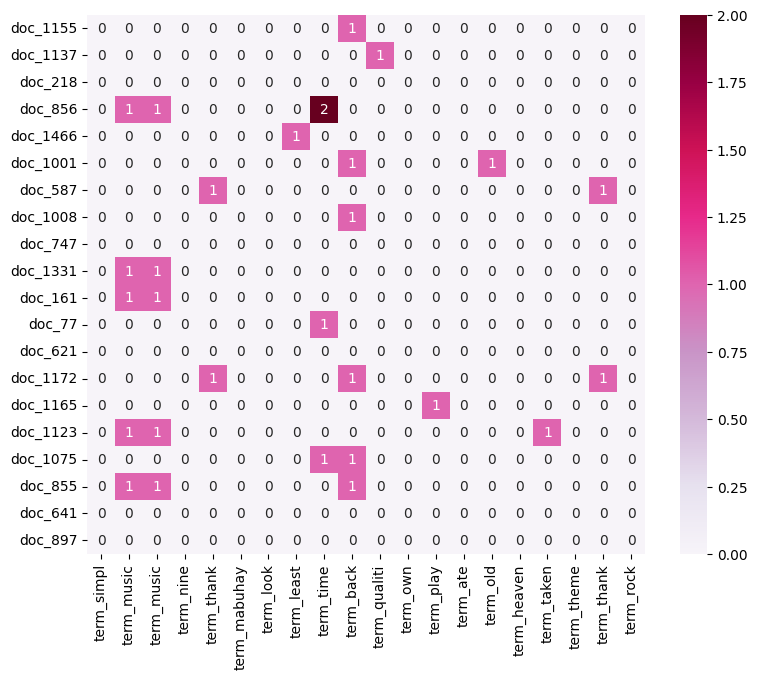

In [13]:
# Select 20 random rows (documents) with non-zero entries from the term-document matrix
sampled_rows = df_counts.nonzero()[0][np.random.choice(len(df_counts.data), 20, replace=False)]

# Select 20 random columns (terms) with non-zero entries from the term-document matrix
sampled_cols = df_counts.nonzero()[1][np.random.choice(len(df_counts.data), 20, replace=False)]

# Create labels for sampled terms and documents
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[sampled_cols]]
plot_y = ["doc_"+ str(i) for i in np.array(df.index)[sampled_rows]]

# Extract term frequencies for the sampled rows and columns
plot_z = df_counts[sampled_rows][:, sampled_cols].toarray()

# Create a DataFrame for plotting with sampled terms as columns and documents as rows
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)

# Set up plot size for the heatmap
plt.subplots(figsize=(9, 7))

# Generate the heatmap using a purple-red color palette, with term frequencies annotated
ax = sns.heatmap(df_todraw, cmap="PuRd", annot=True)

#### Calculate and plot the top 300 term frequencies in the dataset

In [14]:
# Sum term frequencies across all documents
term_frequencies = np.asarray(df_counts.sum(axis=0))[0]

# Sort term indices by frequency in descending order
sorted_indices = np.argsort(-term_frequencies)

# Retrieve sorted term frequencies
sorted_term_frequencies = term_frequencies[sorted_indices]

# Create a bar plot for the top 300 terms and their frequencies
fig = px.bar(x=count_vect.get_feature_names_out()[sorted_indices][:300],
             y=sorted_term_frequencies[:300])

# Rotate x-axis labels for better readability
fig.update_xaxes(tickangle=-90)

# Display the plot
fig.show()

#### Apply logarithmic scaling to term frequencies and plot the top 300 terms

In [15]:
# Calculate the natural logarithm of each sorted term frequency
sorted_term_frequencies_log = [math.log(i) for i in sorted_term_frequencies]

# Create a bar plot for the top 300 terms with log-scaled frequencies
fig = px.bar(x=count_vect.get_feature_names_out()[sorted_indices][:300],
             y=sorted_term_frequencies_log[:300])

# Rotate x-axis labels for better readability
fig.update_xaxes(tickangle=-90)

# Display the plot
fig.show()

#### Generate and display a word cloud based on term frequencies

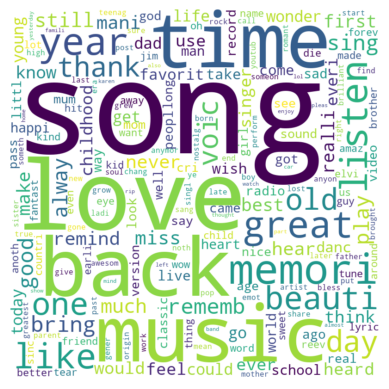

In [16]:
# Create a WordCloud instance with specified width, height, and white background
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
).generate_from_frequencies(dict(zip(count_vect.get_feature_names_out(), term_frequencies)))

# Set up the plot
plt.figure()

# Display the generated word cloud image
plt.imshow(wordcloud, interpolation='bilinear')

# Hide axis
plt.axis('off')

# Display the plot
plt.show()

### Data Preprocessing and Term-Document Matrix Creation

In [17]:
# Get unique sentiment categories from the dataset
categories = df['sentiment'].unique()

# Initialize a dictionary to store DataFrames for each sentiment category
category_dfs = {}

# Create a DataFrame for each sentiment category
for category in categories:
    category_dfs[category] = df[df['sentiment'] == category].copy()

# Define a function to create a term-document DataFrame with the specified vectorizer
def create_term_document_df(df, vectorizer):
    # Choose between CountVectorizer and TfidfVectorizer
    vectorizer = CountVectorizer() if vectorizer == "count" else TfidfVectorizer()
    
    # Transform the cleaned comments into a term-document matrix
    X = vectorizer.fit_transform(df['cleaned_comment'])

    # Get the terms as column names
    words = vectorizer.get_feature_names_out()

    # Create a DataFrame from the term-document matrix
    term_document_df = pd.DataFrame(X.toarray(), columns=words)

    return term_document_df

# Initialize dictionaries to store term-document DataFrames for each category using Count and TF-IDF
term_document_dfs_count = {}
term_document_dfs_tfidf = {}

# Generate term-document matrices for each category using both vectorizers
for category in categories:
    term_document_dfs_count[category] = create_term_document_df(category_dfs[category], "count")
    term_document_dfs_tfidf[category] = create_term_document_df(category_dfs[category], "tfidf")

### Filtering Words in Term-Document Matrices

In [18]:
# Define a function to remove the most and least frequent words from a term-document DataFrame
def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    # Calculate the sum of each word across all documents
    word_sums = term_document_df.sum(axis=0)
    
    # Sort words by their frequency sum
    sorted_words = word_sums.sort_values()
    
    # Determine the number of words to remove from the top and bottom
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    # Identify words to remove (top and bottom frequent words)
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    
    # Drop the identified columns (words) from the DataFrame
    return term_document_df.drop(columns=words_to_remove)

# Initialize dictionaries to store filtered term-document DataFrames for each category
filtered_term_document_dfs_count = {}
filtered_term_document_dfs_tfidf = {}

# Apply filtering to term-document matrices for each category using both Count and TF-IDF matrices
for category in categories:
    filtered_term_document_dfs_count[category] = filter_top_bottom_words_by_sum(term_document_dfs_count[category])
    filtered_term_document_dfs_tfidf[category] = filter_top_bottom_words_by_sum(term_document_dfs_tfidf[category])

### Displaying Filtered Term-Document DataFrames

#### Display Filtered Count Term-Document DataFrames for Specific Categories

In [19]:
category_number = 0
# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs_count[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category not nostalgia:


abil  abl  abroad  absolut  accent  accept  accid  accur  across  act  \
0       0    0       0        0       0       0      0      0       0    0   
1       0    0       0        0       0       0      0      0       0    0   
2       0    0       0        0       0       0      0      0       0    0   
3       0    0       0        0       0       0      0      0       0    0   
4       0    0       0        0       0       0      0      0       0    0   
..    ...  ...     ...      ...     ...     ...    ...    ...     ...  ...   
744     0    0       0        0       0       0      0      0       0    0   
745     0    0       0        0       0       0      0      0       0    0   
746     0    0       0        0       0       0      0      0       0    0   
747     0    0       0        0       0       0      0      0       0    0   
748     0    0       0        0       0       0      0      0       0    0   

     ...  yet  younger  youngest  youngster  youth  youtub  yr  yuo  zealand  \
0    ...    0        0         0          0      0       0   0    0        0   
1    ...    0        0         0          0      0       0   0    0        0   
2    ...    0        0         0          0      0       0   0    0        0   
3    ...    0        0         0          0      0       0   0    0        0   
4    ...    0        0         0          0      0       0   0    0        0   
..   ...  ...      ...       ...        ...    ...     ...  ..  ...      ...   
744  ...    0        0         0          0      0       0   0    0        0   
745  ...    0        0         0          0      0       0   0    0        0   
746  ...    0        0         0          0      0       0   0    0        0   
747  ...    0        0         0          0      0       0   0    0        0   
748  ...    0        0         0          0      0       0   0    0        0   

     zulu  
0       0  
1       0  
2       0  
3       0  
4       0  
..    ...  
744     0  
745     0  
746     0  
747     0  
748     0  

[749 rows x 1825 columns]

In [20]:
category_number = 1
# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs_count[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category nostalgia:


abl  absolut  absorb  accid  acknowledg  across  actual  admit  ador  \
0      0        0       0      0           0       0       0      0     0   
1      0        0       0      0           0       0       0      0     0   
2      0        0       0      0           0       0       0      0     0   
3      0        0       0      0           0       0       0      0     0   
4      0        0       0      0           0       0       0      0     0   
..   ...      ...     ...    ...         ...     ...     ...    ...   ...   
745    0        0       0      0           0       0       0      0     0   
746    0        0       0      0           0       0       0      0     0   
747    0        0       0      0           0       0       0      0     0   
748    0        0       0      0           0       0       0      0     0   
749    0        0       0      0           0       0       0      0     0   

     adult  ...  yester  yesterday  yet  yo  yokel  younger  youngster  youth  \
0        0  ...       0          0    0   0      0        0          0      0   
1        0  ...       0          0    0   0      0        0          0      0   
2        0  ...       0          0    0   0      0        0          0      0   
3        0  ...       0          0    0   0      0        0          0      0   
4        0  ...       0          0    0   0      0        0          0      0   
..     ...  ...     ...        ...  ...  ..    ...      ...        ...    ...   
745      0  ...       0          0    0   0      0        0          0      0   
746      0  ...       0          0    0   0      0        0          0      0   
747      0  ...       0          0    0   0      0        0          0      0   
748      0  ...       0          0    0   0      0        0          0      0   
749      0  ...       0          0    0   0      0        0          0      0   

     youtub  yr  
0         0   0  
1         0   0  
2         0   0  
3         0   0  
4         0   0  
..      ...  ..  
745       0   0  
746       0   0  
747       0   0  
748       0   0  
749       0   0  

[750 rows x 1582 columns]

#### Display Filtered TF-IDF Term-Document DataFrames for Specific Categories

In [21]:
category_number = 0
# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs_tfidf[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category not nostalgia:


aband  abil  abl  abroad  absolut  accent  accept  accid  accur  across  \
0      0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
1      0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
2      0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
3      0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
4      0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
..     ...   ...  ...     ...      ...     ...     ...    ...    ...     ...   
744    0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
745    0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
746    0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
747    0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   
748    0.0   0.0  0.0     0.0      0.0     0.0     0.0    0.0    0.0     0.0   

     ...  yet  younger  youngest  youngster  youth  youtub   yr  yuo  zealand  \
0    ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
1    ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
2    ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
3    ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
4    ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
..   ...  ...      ...       ...        ...    ...     ...  ...  ...      ...   
744  ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
745  ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
746  ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
747  ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   
748  ...  0.0      0.0       0.0        0.0    0.0     0.0  0.0  0.0      0.0   

     zulu  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
..    ...  
744   0.0  
745   0.0  
746   0.0  
747   0.0  
748   0.0  

[749 rows x 1825 columns]

In [22]:
category_number = 1
# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs_tfidf[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category nostalgia:


abl  absolut  absorb  accid  acknowledg  across  actual  admit  ador  \
0    0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
1    0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
2    0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
3    0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
4    0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
..   ...      ...     ...    ...         ...     ...     ...    ...   ...   
745  0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
746  0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
747  0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
748  0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   
749  0.0      0.0     0.0    0.0         0.0     0.0     0.0    0.0   0.0   

     adult  ...  yesterday  yet   yo  yokel  younger  youngster  youth  \
0      0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
1      0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
2      0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
3      0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
4      0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
..     ...  ...        ...  ...  ...    ...      ...        ...    ...   
745    0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
746    0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
747    0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
748    0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   
749    0.0  ...        0.0  0.0  0.0    0.0      0.0        0.0    0.0   

     youtub   yr       yup  
0       0.0  0.0  0.000000  
1       0.0  0.0  0.000000  
2       0.0  0.0  0.000000  
3       0.0  0.0  0.000000  
4       0.0  0.0  0.000000  
..      ...  ...       ...  
745     0.0  0.0  0.411514  
746     0.0  0.0  0.000000  
747     0.0  0.0  0.000000  
748     0.0  0.0  0.000000  
749     0.0  0.0  0.000000  

[750 rows x 1582 columns]

### Converting Term-Document DataFrames to Transactional Databases

#### Convert Count Term-Document DataFrames to Transactional Databases

In [23]:
# Loop through the dictionary of term-document DataFrames
for category in term_document_dfs_count:
    # Replace dots with underscores in the category name to avoid errors in the file creation
    category_safe = category.replace(' ', '_')
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(term_document_dfs_count[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}_count.csv', '>=', 1)

#### Convert TF-IDF Term-Document DataFrames to Transactional Databases

In [24]:
# Loop through the dictionary of term-document DataFrames
for category in term_document_dfs_tfidf:
    # Replace dots with underscores in the category name to avoid errors in the file creation
    category_safe = category.replace(' ', '_')
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(term_document_dfs_tfidf[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}_tfidf.csv', '>=', 0.1)

#### Convert Filtered Count Term-Document DataFrames to Transactional Databases

In [25]:
# Loop through the dictionary of term-document DataFrames
for category in filtered_term_document_dfs_count:
    # Replace dots with underscores in the category name to avoid errors in the file creation
    category_safe = category.replace(' ', '_')
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(filtered_term_document_dfs_count[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}_filtered_count.csv', '>=', 1)

#### Convert Filtered TF-IDF Term-Document DataFrames to Transactional Databases

In [26]:
# Loop through the dictionary of term-document DataFrames
for category in filtered_term_document_dfs_tfidf:
    # Replace dots with underscores in the category name to avoid errors in the file creation
    category_safe = category.replace(' ', '_')
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(filtered_term_document_dfs_tfidf[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}_filtered_tfidf.csv', '>=', 0.1)

### Analyzing Transactional Databases

#### Running Analysis on Count Term-Document Databases

Database size (total no of transactions) : 750
Number of items : 1682
Minimum Transaction Size : 2
Average Transaction Size : 12.168
Maximum Transaction Size : 42
Standard Deviation Transaction Size : 7.434947388291773
Variance in Transaction Sizes : 55.352245660881174
Sparsity : 0.9927657550535077


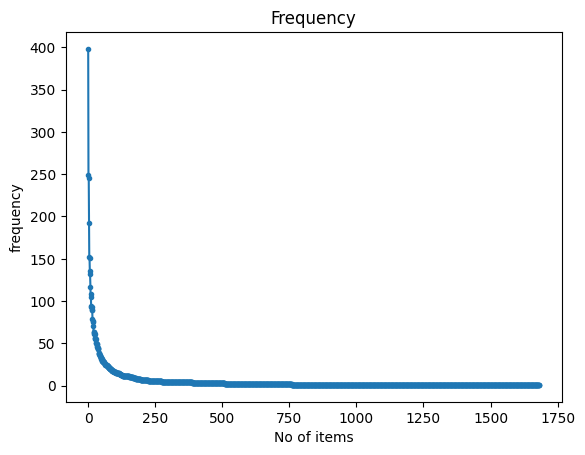

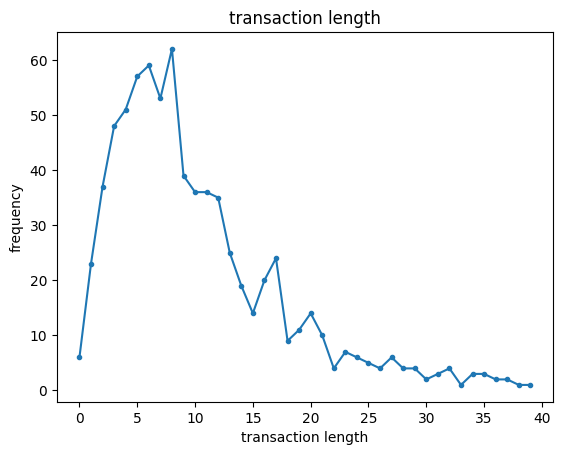

In [27]:
obj = tds.TransactionalDatabase('td_freq_db_nostalgia_count.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 749
Number of items : 1941
Minimum Transaction Size : 3
Average Transaction Size : 11.018691588785046
Maximum Transaction Size : 49
Standard Deviation Transaction Size : 6.166767639628634
Variance in Transaction Sizes : 38.07986406117247
Sparsity : 0.9943231882592555


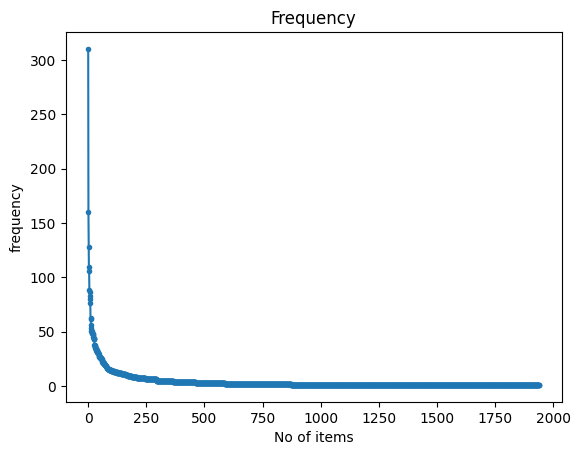

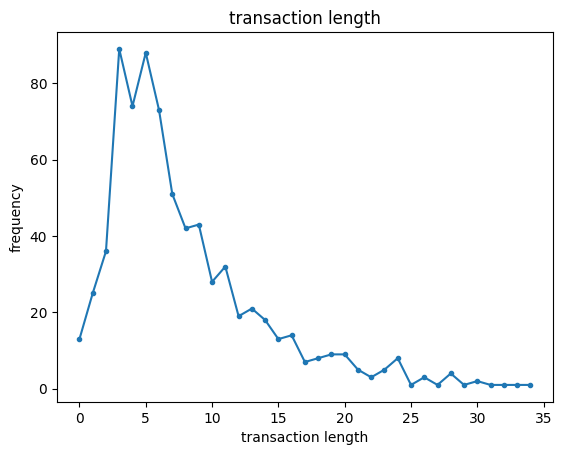

In [28]:
obj = tds.TransactionalDatabase('td_freq_db_not_nostalgia_count.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

#### Running Analysis on TF-IDF Term-Document Databases

Database size (total no of transactions) : 750
Number of items : 1682
Minimum Transaction Size : 2
Average Transaction Size : 11.652
Maximum Transaction Size : 36
Standard Deviation Transaction Size : 6.523002580611682
Variance in Transaction Sizes : 42.60637116154873
Sparsity : 0.9930725326991676


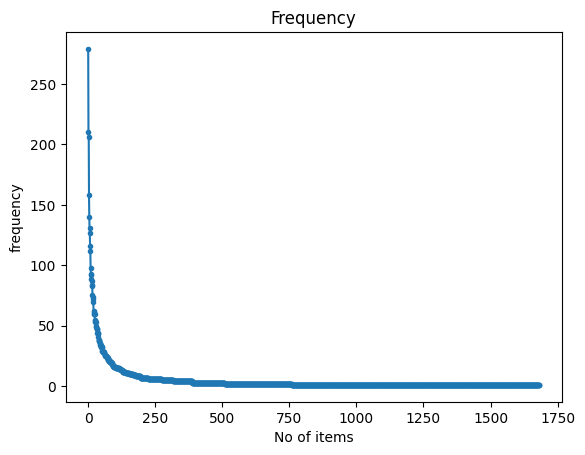

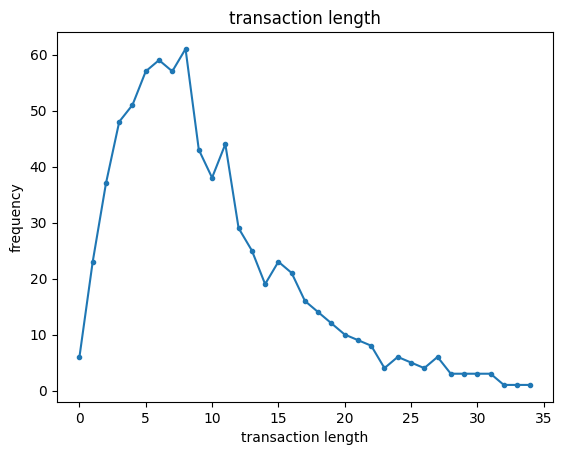

In [29]:
obj = tds.TransactionalDatabase('td_freq_db_nostalgia_tfidf.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 749
Number of items : 1941
Minimum Transaction Size : 3
Average Transaction Size : 10.830440587449933
Maximum Transaction Size : 42
Standard Deviation Transaction Size : 5.792987099835456
Variance in Transaction Sizes : 33.60356411043602
Sparsity : 0.9944201748647862


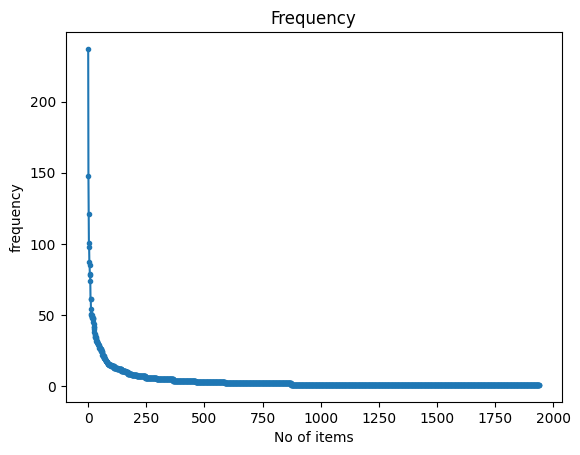

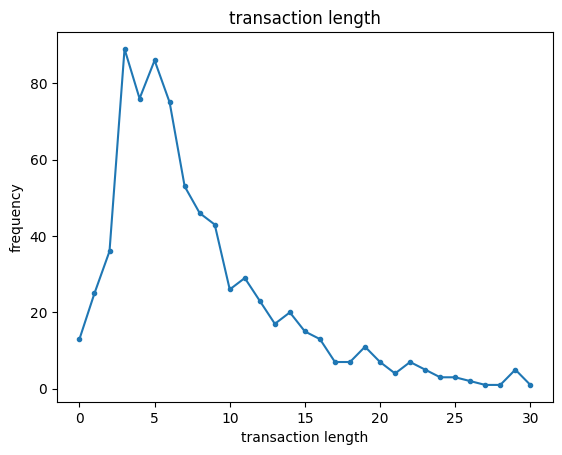

In [30]:
obj = tds.TransactionalDatabase('td_freq_db_not_nostalgia_tfidf.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

#### Running Analysis on Filtered Count Term-Document Databases

Database size (total no of transactions) : 688
Number of items : 1582
Minimum Transaction Size : 1
Average Transaction Size : 5.988372093023256
Maximum Transaction Size : 30
Standard Deviation Transaction Size : 5.2045243869257565
Variance in Transaction Sizes : 27.12650214955486
Sparsity : 0.9962146826213507


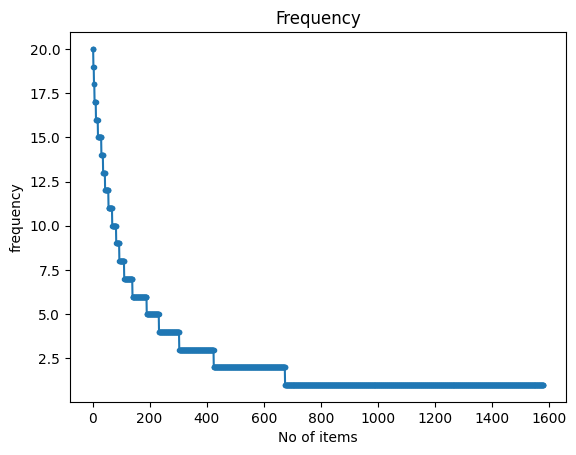

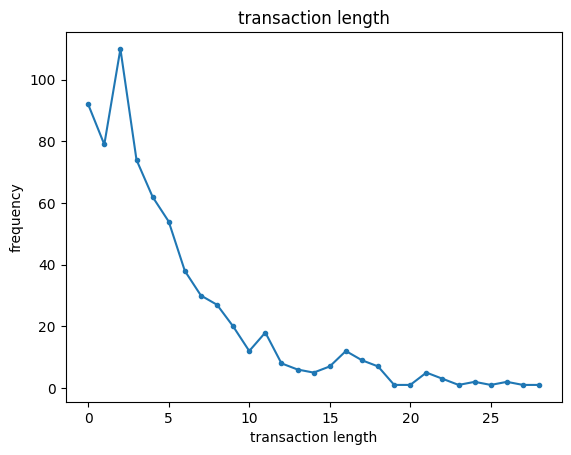

In [31]:
obj = tds.TransactionalDatabase('td_freq_db_nostalgia_filtered_count.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 737
Number of items : 1825
Minimum Transaction Size : 1
Average Transaction Size : 6.1166892808683855
Maximum Transaction Size : 34
Standard Deviation Transaction Size : 4.675053562241915
Variance in Transaction Sizes : 21.885821632942008
Sparsity : 0.9966483894351406


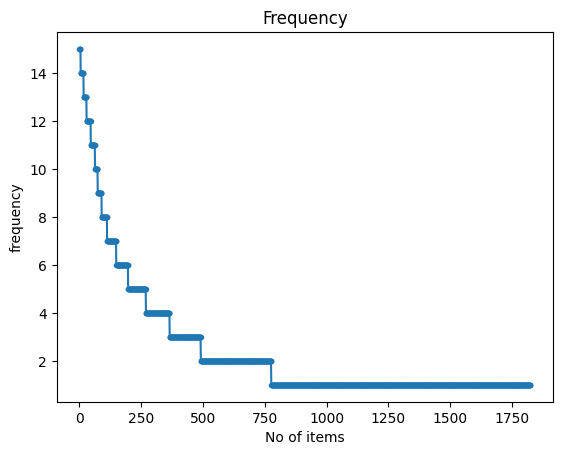

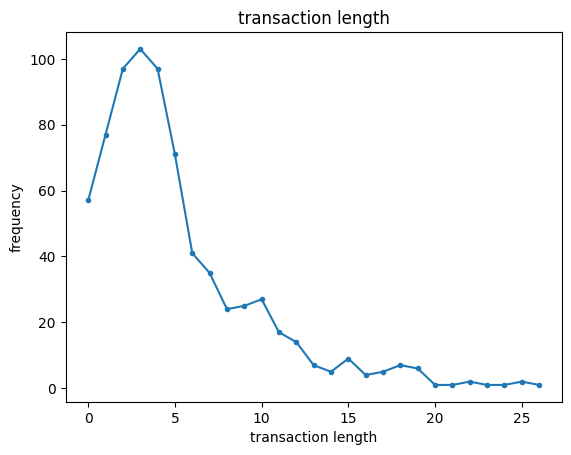

In [32]:
obj = tds.TransactionalDatabase('td_freq_db_not_nostalgia_filtered_count.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

#### Running Analysis on Filtered TF-IDF Term-Document Databases

Database size (total no of transactions) : 678
Number of items : 1582
Minimum Transaction Size : 1
Average Transaction Size : 6.101769911504425
Maximum Transaction Size : 30
Standard Deviation Transaction Size : 5.288153660664532
Variance in Transaction Sizes : 28.0058757401864
Sparsity : 0.996143002584384


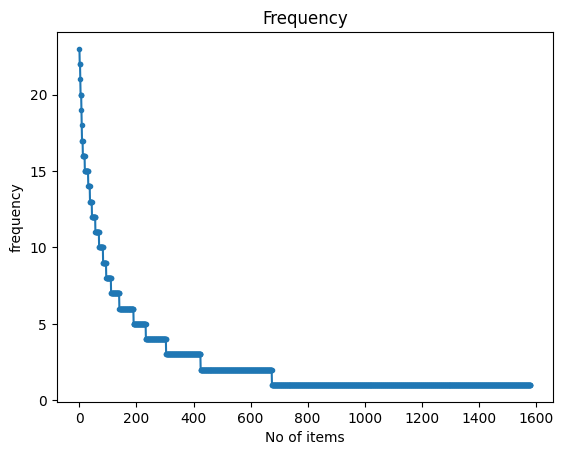

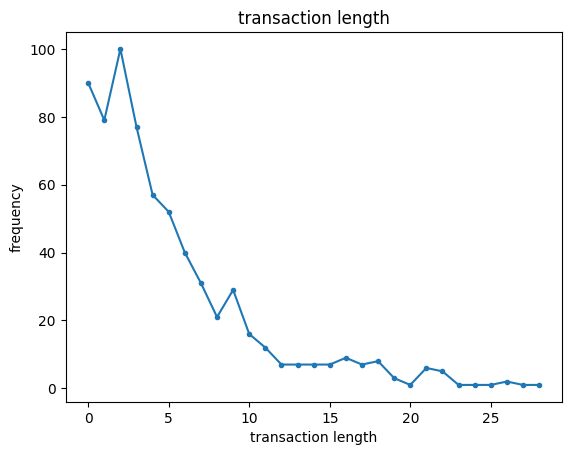

In [33]:
obj = tds.TransactionalDatabase('td_freq_db_nostalgia_filtered_tfidf.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 730
Number of items : 1825
Minimum Transaction Size : 1
Average Transaction Size : 6.1808219178082195
Maximum Transaction Size : 31
Standard Deviation Transaction Size : 4.65407929874123
Variance in Transaction Sizes : 21.69016667606216
Sparsity : 0.9966132482642147


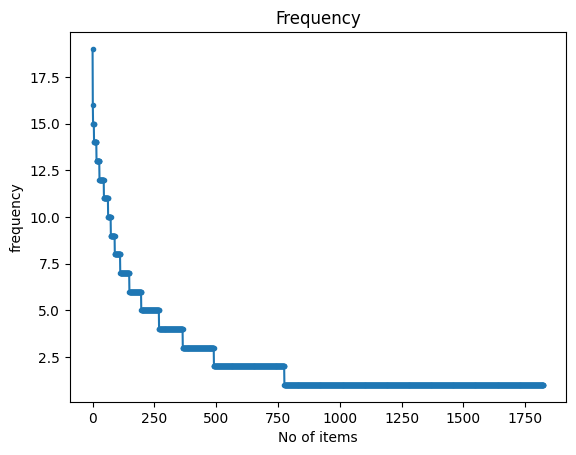

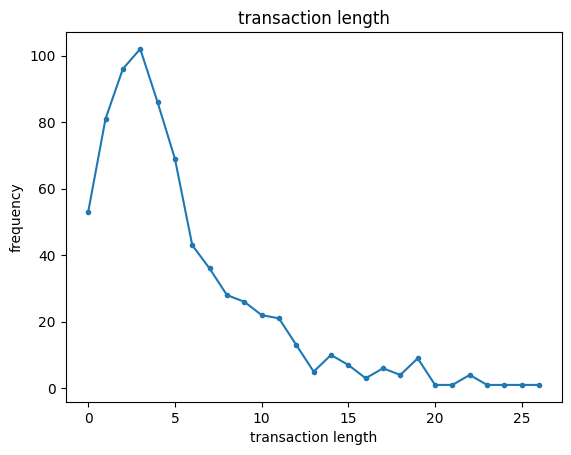

In [34]:
obj = tds.TransactionalDatabase('td_freq_db_not_nostalgia_filtered_tfidf.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

### Mining Patterns from Transactional Data

In [35]:
# Define the input file that contains the transactional data
iFiles = [
    'td_freq_db_nostalgia_count.csv',
    'td_freq_db_not_nostalgia_count.csv',
    'td_freq_db_nostalgia_filtered_count.csv',
    'td_freq_db_not_nostalgia_filtered_count.csv',
    'td_freq_db_nostalgia_tfidf.csv',
    'td_freq_db_not_nostalgia_tfidf.csv',
    'td_freq_db_nostalgia_filtered_tfidf.csv',
    'td_freq_db_not_nostalgia_filtered_tfidf.csv',
]

# Create a list of algorithms and the parameters to use for each
algorithms = [
    {
        'algo': FPGrowth.FPGrowth,
        'params': np.arange(3, 10, 3)
    },
    {
        'algo': FAE.FAE,
        'params': np.arange(10, 30, 5)
    },
    {
        'algo': MaxFPGrowth.MaxFPGrowth,
        'params': np.arange(3, 10, 3)
    },
]

# Initialize an empty list to store the results
results = []

# Iterate over the list of algorithms
for iFile in iFiles:
    for algorithm in algorithms:
        algo = algorithm['algo']  # Get the algorithm class
        for param in algorithm['params']:  # Iterate over the parameter values
            # Instantiate the algorithm object with the input file and parameter
            obj = algo(iFile, param)
            obj.mine()  # Run the mining process

            # Get the patterns as a DataFrame and store the results
            freq_pattern = obj.getPatternsAsDataFrame()
            results.append(
                {
                    'iFile': iFile,
                    'algorithm': algo.__name__,  # Store the algorithm name
                    'parameter': str(param),  # Store the parameter value
                    'patterns': str(len(freq_pattern)),  # Store the number of patterns found
                    'runtime': str(obj.getRuntime()),  # Store the runtime of the algorithm
                    'df': freq_pattern,
                }
            )

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
 TopK frequent patterns were successfully generated using FAE algorithm.
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Frequent patterns were generated suc

In [36]:
# Print the results for each algorithm and parameter combination
for result in results:
    print("iFile:", result['iFile'])
    print("Algorithm:", result['algorithm'])
    print("Parameter:", result['parameter'])
    print('Total No of patterns:', result['patterns'])
    print('Runtime:', result['runtime'], "\n")

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FPGrowth
Parameter: 3
Total No of patterns: 14192
Runtime: 0.14498615264892578 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FPGrowth
Parameter: 6
Total No of patterns: 2674
Runtime: 0.30774497985839844 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FPGrowth
Parameter: 9
Total No of patterns: 1215
Runtime: 0.03512883186340332 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FAE
Parameter: 10
Total No of patterns: 10
Runtime: 0.006206035614013672 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FAE
Parameter: 15
Total No of patterns: 15
Runtime: 0.00510716438293457 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FAE
Parameter: 20
Total No of patterns: 20
Runtime: 0.005529880523681641 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: FAE
Parameter: 25
Total No of patterns: 25
Runtime: 0.005551815032958984 

iFile: td_freq_db_nostalgia_count.csv
Algorithm: MaxFPGrowth
Parameter: 3
Total No of patterns: 4387
Runtime: 0.23656

Based on the result patterns, FPGrowth with minSupport 3 has the most mined pattern result. Thus, for this homework, I'm utilizing FPGrowth with minSupport 3 as the parameters. The index where the result use FPGrowth algorithm and minSupport 3 for Count, Filtered Count, TF-IDF, and Filtered TF-IDF respectively are at 0, 10, 20, 30, 40, 50, 60, and 70.

### Analyzing Found Patterns in Transactional Data

In [37]:
# We group together all of the dataframes related to our found patterns
dfs_count = [results[0]['df'], results[10]['df']]
dfs_filtered_count = [results[20]['df'], results[30]['df']]
dfs_tfidf = [results[40]['df'], results[50]['df']]
dfs_filtered_tfidf = [results[60]['df'], results[70]['df']]


# Initialize dictionaries to count occurrences of patterns in each category
pattern_counts_count = {}
pattern_counts_filtered_count = {}
pattern_counts_tfidf = {}
pattern_counts_filtered_tfidf = {}

# Count patterns in each category
for data in dfs_count:
    for pattern in data['Patterns']:
        if pattern not in pattern_counts_count:
            pattern_counts_count[pattern] = 1
        else:
            pattern_counts_count[pattern] += 1

for data in dfs_filtered_count:
    for pattern in data['Patterns']:
        if pattern not in pattern_counts_filtered_count:
            pattern_counts_filtered_count[pattern] = 1
        else:
            pattern_counts_filtered_count[pattern] += 1

for data in dfs_tfidf:
    for pattern in data['Patterns']:
        if pattern not in pattern_counts_tfidf:
            pattern_counts_tfidf[pattern] = 1
        else:
            pattern_counts_tfidf[pattern] += 1

for data in dfs_filtered_tfidf:
    for pattern in data['Patterns']:
        if pattern not in pattern_counts_filtered_tfidf:
            pattern_counts_filtered_tfidf[pattern] = 1
        else:
            pattern_counts_filtered_tfidf[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns_count = {pattern for pattern, count in pattern_counts_count.items() if count == 1}
unique_patterns_filtered_count = {pattern for pattern, count in pattern_counts_filtered_count.items() if count == 1}
unique_patterns_tfidf = {pattern for pattern, count in pattern_counts_tfidf.items() if count == 1}
unique_patterns_filtered_tfidf = {pattern for pattern, count in pattern_counts_filtered_tfidf.items() if count == 1}

# Calculate the total number of patterns across all categories
total_patterns_count_count = sum(len(data) for data in dfs_count)
total_patterns_count_filtered_count = sum(len(data) for data in dfs_filtered_count)
total_patterns_count_tfidf = sum(len(data) for data in dfs_tfidf)
total_patterns_count_filtered_tfidf = sum(len(data) for data in dfs_filtered_tfidf)

# Calculate how many patterns were discarded
discarded_patterns_count_count = total_patterns_count_count - len(unique_patterns_count)
discarded_patterns_count_filtered_count = total_patterns_count_filtered_count - len(unique_patterns_filtered_count)
discarded_patterns_count_tfidf = total_patterns_count_tfidf - len(unique_patterns_tfidf)
discarded_patterns_count_filtered_tfidf = total_patterns_count_filtered_tfidf - len(unique_patterns_filtered_tfidf)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs_count = [data[data['Patterns'].isin(unique_patterns_count)] for data in dfs_count]
filtered_dfs_filtered_count = [data[data['Patterns'].isin(unique_patterns_filtered_count)] for data in dfs_filtered_count]
filtered_dfs_tfidf = [data[data['Patterns'].isin(unique_patterns_tfidf)] for data in dfs_tfidf]
filtered_dfs_filtered_tfidf = [data[data['Patterns'].isin(unique_patterns_filtered_tfidf)] for data in dfs_filtered_tfidf]

# Merge and sort the filtered dataframes into a final dataframe
final_pattern_df_count = pd.concat(filtered_dfs_count, ignore_index=True).sort_values(by='Support', ascending=False)
final_pattern_df_filtered_count = pd.concat(filtered_dfs_filtered_count, ignore_index=True).sort_values(by='Support', ascending=False)
final_pattern_df_tfidf = pd.concat(filtered_dfs_tfidf, ignore_index=True).sort_values(by='Support', ascending=False)
final_pattern_df_filtered_tfidf = pd.concat(filtered_dfs_filtered_tfidf, ignore_index=True).sort_values(by='Support', ascending=False)

# Display the final result and print the number of discarded patterns
print(final_pattern_df_count)
print(f"Number of patterns discarded: {discarded_patterns_count_count}")
print(final_pattern_df_filtered_count)
print(f"Number of patterns discarded: {discarded_patterns_count_filtered_count}")
print(final_pattern_df_tfidf)
print(f"Number of patterns discarded: {discarded_patterns_count_tfidf}")
print(final_pattern_df_filtered_tfidf)
print(f"Number of patterns discarded: {discarded_patterns_count_filtered_tfidf}")

                     Patterns  Support
12901             memori song      130
12899             memori back      123
12857              bring back      120
12855            bring memori      106
12856       bring memori back       95
...                       ...      ...
5891          would year back        3
5892     would year back song        3
5893        would year memori        3
5894   would year memori song        3
7746          best bring song        3

[15493 rows x 2 columns]
Number of patterns discarded: 2580
    Patterns  Support
261     well       20
263   friend       20
262      way       20
260  nostalg       19
259    think       18
..       ...      ...
272    known        3
271     flow        3
270     book        3
269  qualiti        3
286   recogn        3

[572 rows x 2 columns]
Number of patterns discarded: 462
               Patterns  Support
6319         bring back      104
6352        back memori      101
6071             remind       92
6317       bring 

### Tokenize and Vectorize Comments

In [38]:
# Create a copy of the original DataFrame
df_copy = df.copy()

# Tokenize the sentences into sets of unique words for easy pattern matching 
df_copy['tokenized_comment'] = df_copy['cleaned_comment'].str.split().apply(set)

# Generate term-document matrices using CountVectorizer and TfidfVectorizer
count_vect = CountVectorizer()
X_tdm_count = count_vect.fit_transform(df_copy['cleaned_comment'])
terms_count = count_vect.get_feature_names_out()
tdm_df_count = pd.DataFrame(X_tdm_count.toarray(), columns=terms_count, index=df_copy.index)

tfidf_vect = TfidfVectorizer()
X_tdm_tfidf = tfidf_vect.fit_transform(df_copy['cleaned_comment'])
terms_tfidf = tfidf_vect.get_feature_names_out()
tdm_df_tfidf = pd.DataFrame(X_tdm_tfidf.toarray(), columns=terms_tfidf, index=df_copy.index)

### Define a Function to Generate Pattern Matrices

In [39]:
# This function creates a pattern matrix by checking for pattern presence in each document
def create_pattern_matrix(patterns, df_tokenized):
    # Initialize pattern matrix with 0s
    pattern_matrix = pd.DataFrame(0, index=df_tokenized.index, columns=patterns['Patterns'])
    
    # Convert patterns to sets for fast checking
    patterns_set = [set(pattern.split()) for pattern in patterns['Patterns']]
    
    # Populate pattern matrix with presence (1) or absence (0) of each pattern
    for idx, pattern_words in enumerate(patterns_set):
        pattern_matrix.iloc[:, idx] = df_tokenized['tokenized_comment'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

    return pattern_matrix

### Generate Pattern Matrices and Augment Term-Document Matrices

In [40]:
# Define pattern DataFrames for each category
pattern_dfs = {
    'count': final_pattern_df_count,
    'filtered_count': final_pattern_df_filtered_count,
    'tfidf': final_pattern_df_tfidf,
    'filtered_tfidf': final_pattern_df_filtered_tfidf
}

# Create a dictionary to store augmented DataFrames
augmented_dfs = {}

# Generate and store augmented DataFrames
for key, pattern_df in pattern_dfs.items():
    pattern_matrix = create_pattern_matrix(pattern_df, df_copy)
    if 'tfidf' in key:
        # For tfidf-based augmentation, use the tfidf term-document matrix
        augmented_dfs[key] = pd.concat([tdm_df_tfidf, pattern_matrix], axis=1)
    else:
        # For count-based augmentation, use the count term-document matrix
        augmented_dfs[key] = pd.concat([tdm_df_count, pattern_matrix], axis=1)

### Display Results

# Print augmented DataFrames for each category
for key, augmented_df in augmented_dfs.items():
    print(f"Augmented DataFrame for {key}:")
    print(augmented_df)

Augmented DataFrame for count:
      aband  abil  abl  abroad  absolut  absorb  accent  accept  accid  accur  \
0         0     0    0       0        0       0       0       0      0      0   
1         0     0    0       0        0       0       0       0      0      0   
2         0     0    0       0        0       0       0       0      0      0   
3         0     0    0       0        0       0       0       0      0      0   
4         0     0    0       0        0       0       0       0      0      0   
...     ...   ...  ...     ...      ...     ...     ...     ...    ...    ...   
1495      0     0    0       0        0       0       0       0      0      0   
1496      0     0    0       0        0       0       0       0      0      0   
1497      0     0    0       0        0       0       0       0      0      0   
1498      0     0    0       0        0       0       0       0      0      0   
1499      0     0    0       0        0       0       0       0      0      0 

### Dimensionality Reduction and Visualization

In [47]:
# Function to reduce dimensions and plot the results
def reduce_and_plot(data, reduction_methods, titles, plot_name, categories, colors, sentiment_column):
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    fig.suptitle(f'PCA, t-SNE, and UMAP Comparison {plot_name}')
    
    for ax, (method, title) in zip(axes, zip(reduction_methods, titles)):
        X_reduced = method.fit_transform(data)
        for c, category in zip(colors, categories):
            xs = X_reduced[df[sentiment_column] == category].T[0]
            ys = X_reduced[df[sentiment_column] == category].T[1]
            ax.scatter(xs, ys, c=c, marker='o', label=category)
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend(loc='upper right')
        ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    
    plt.show()

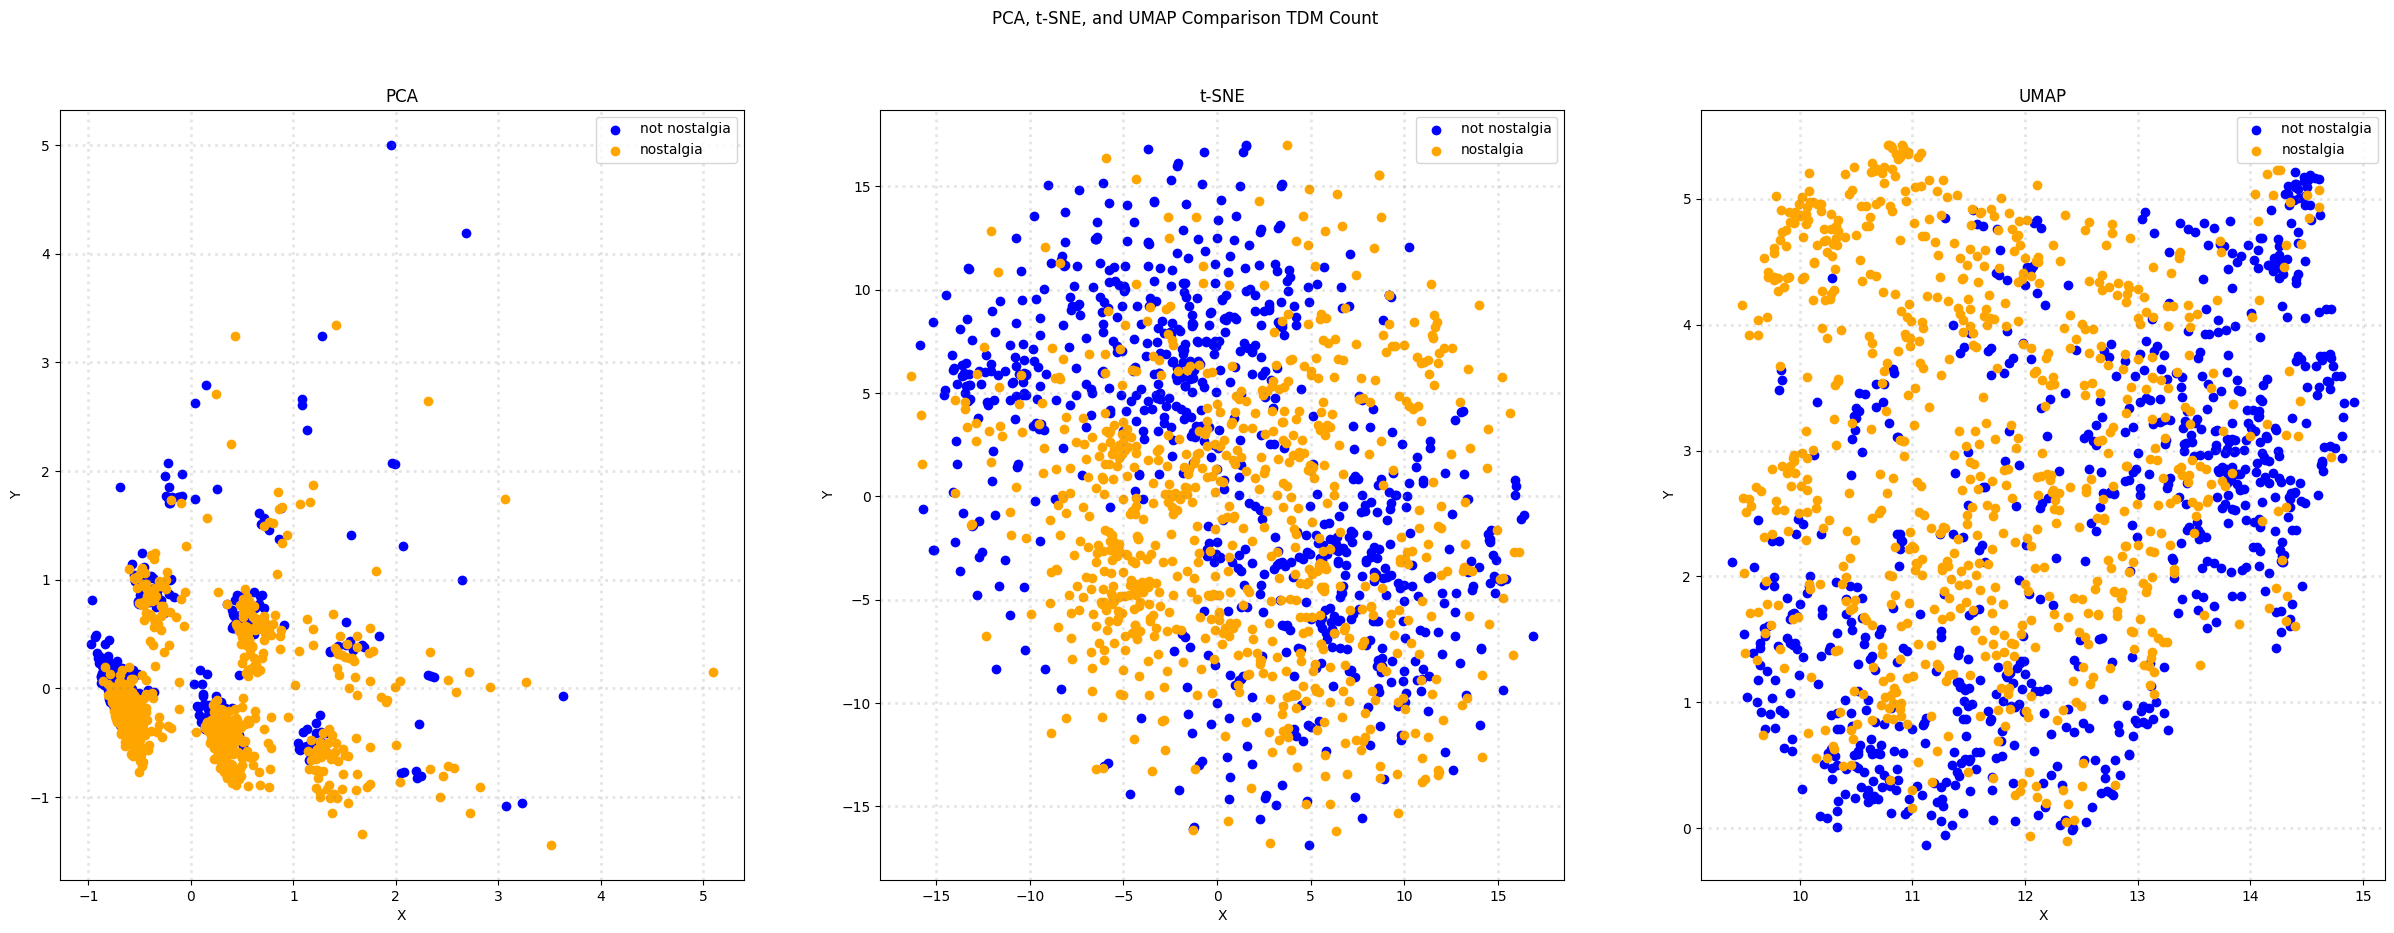

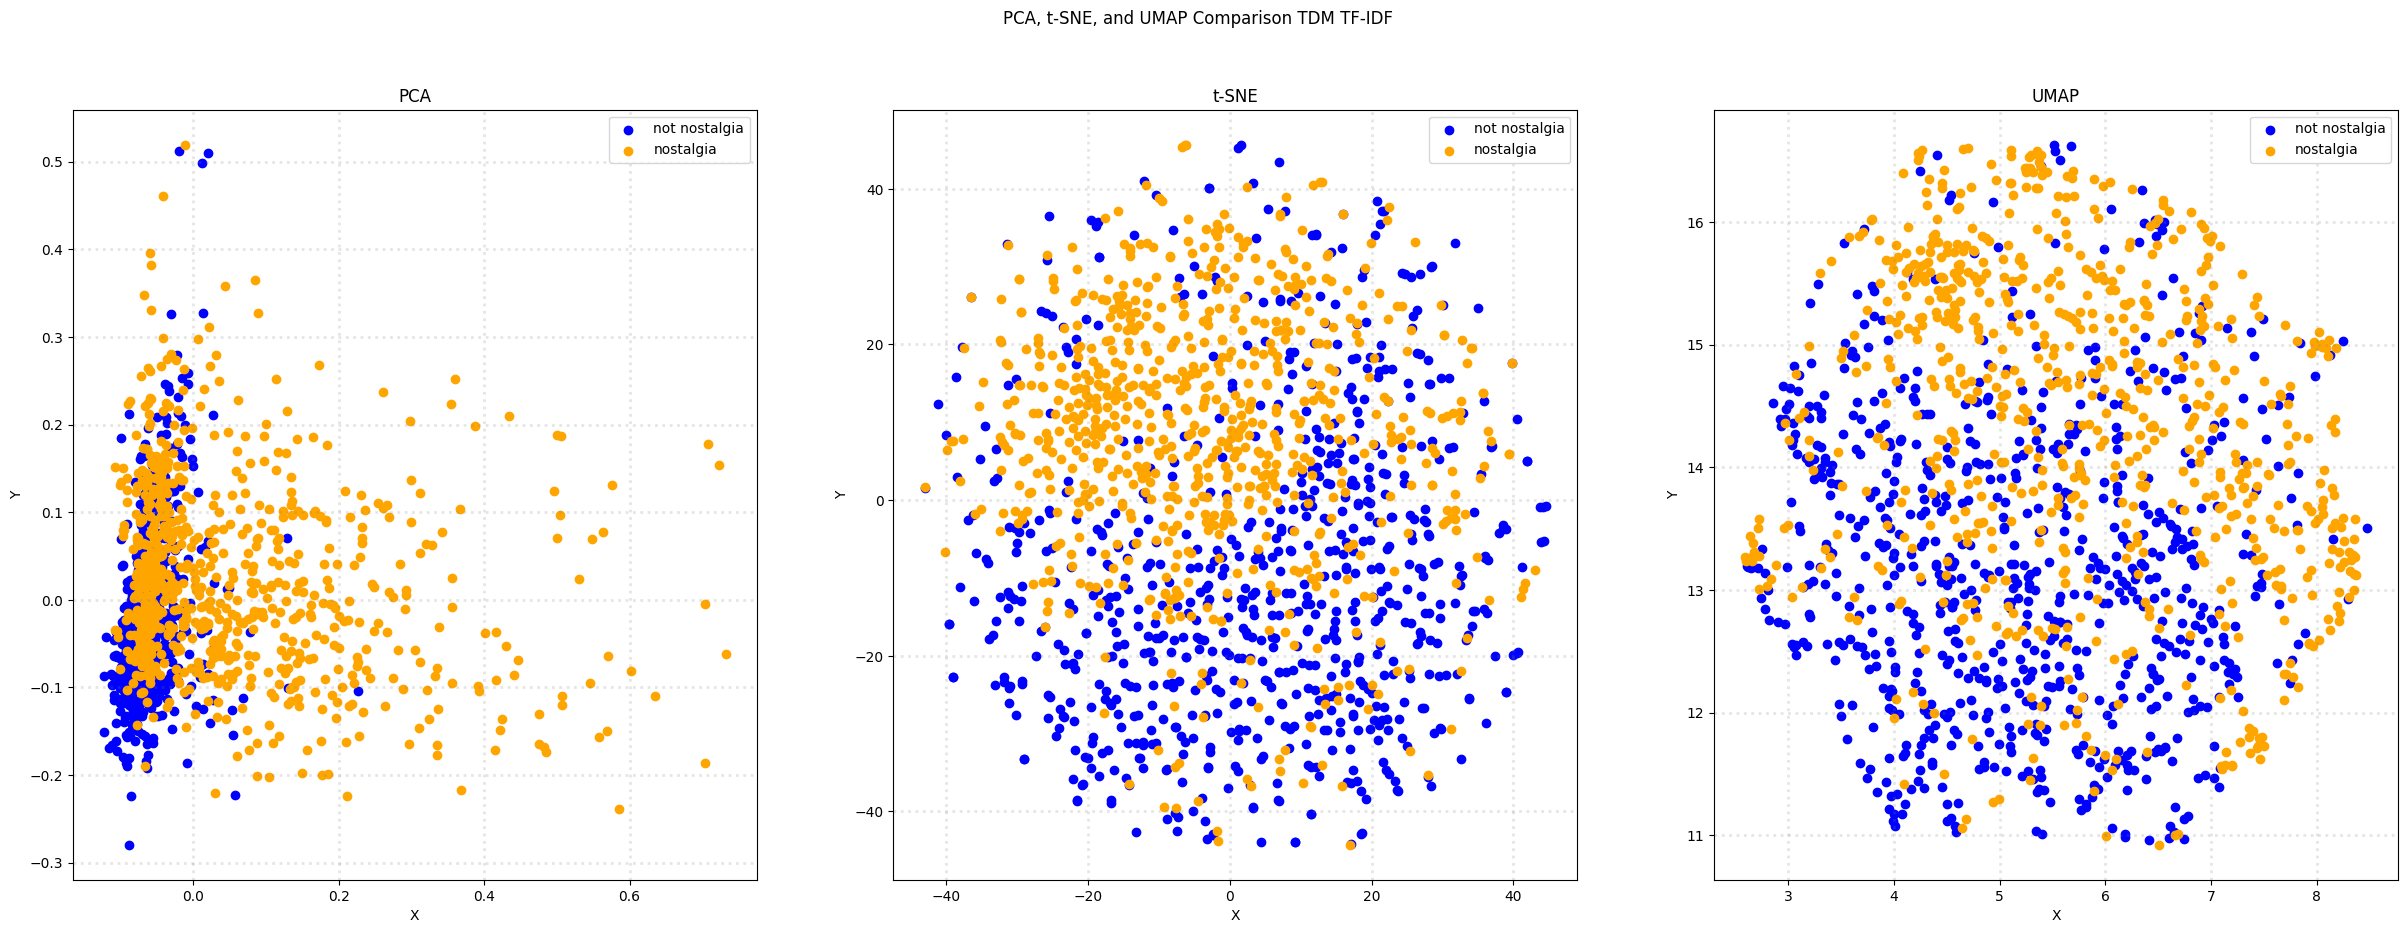

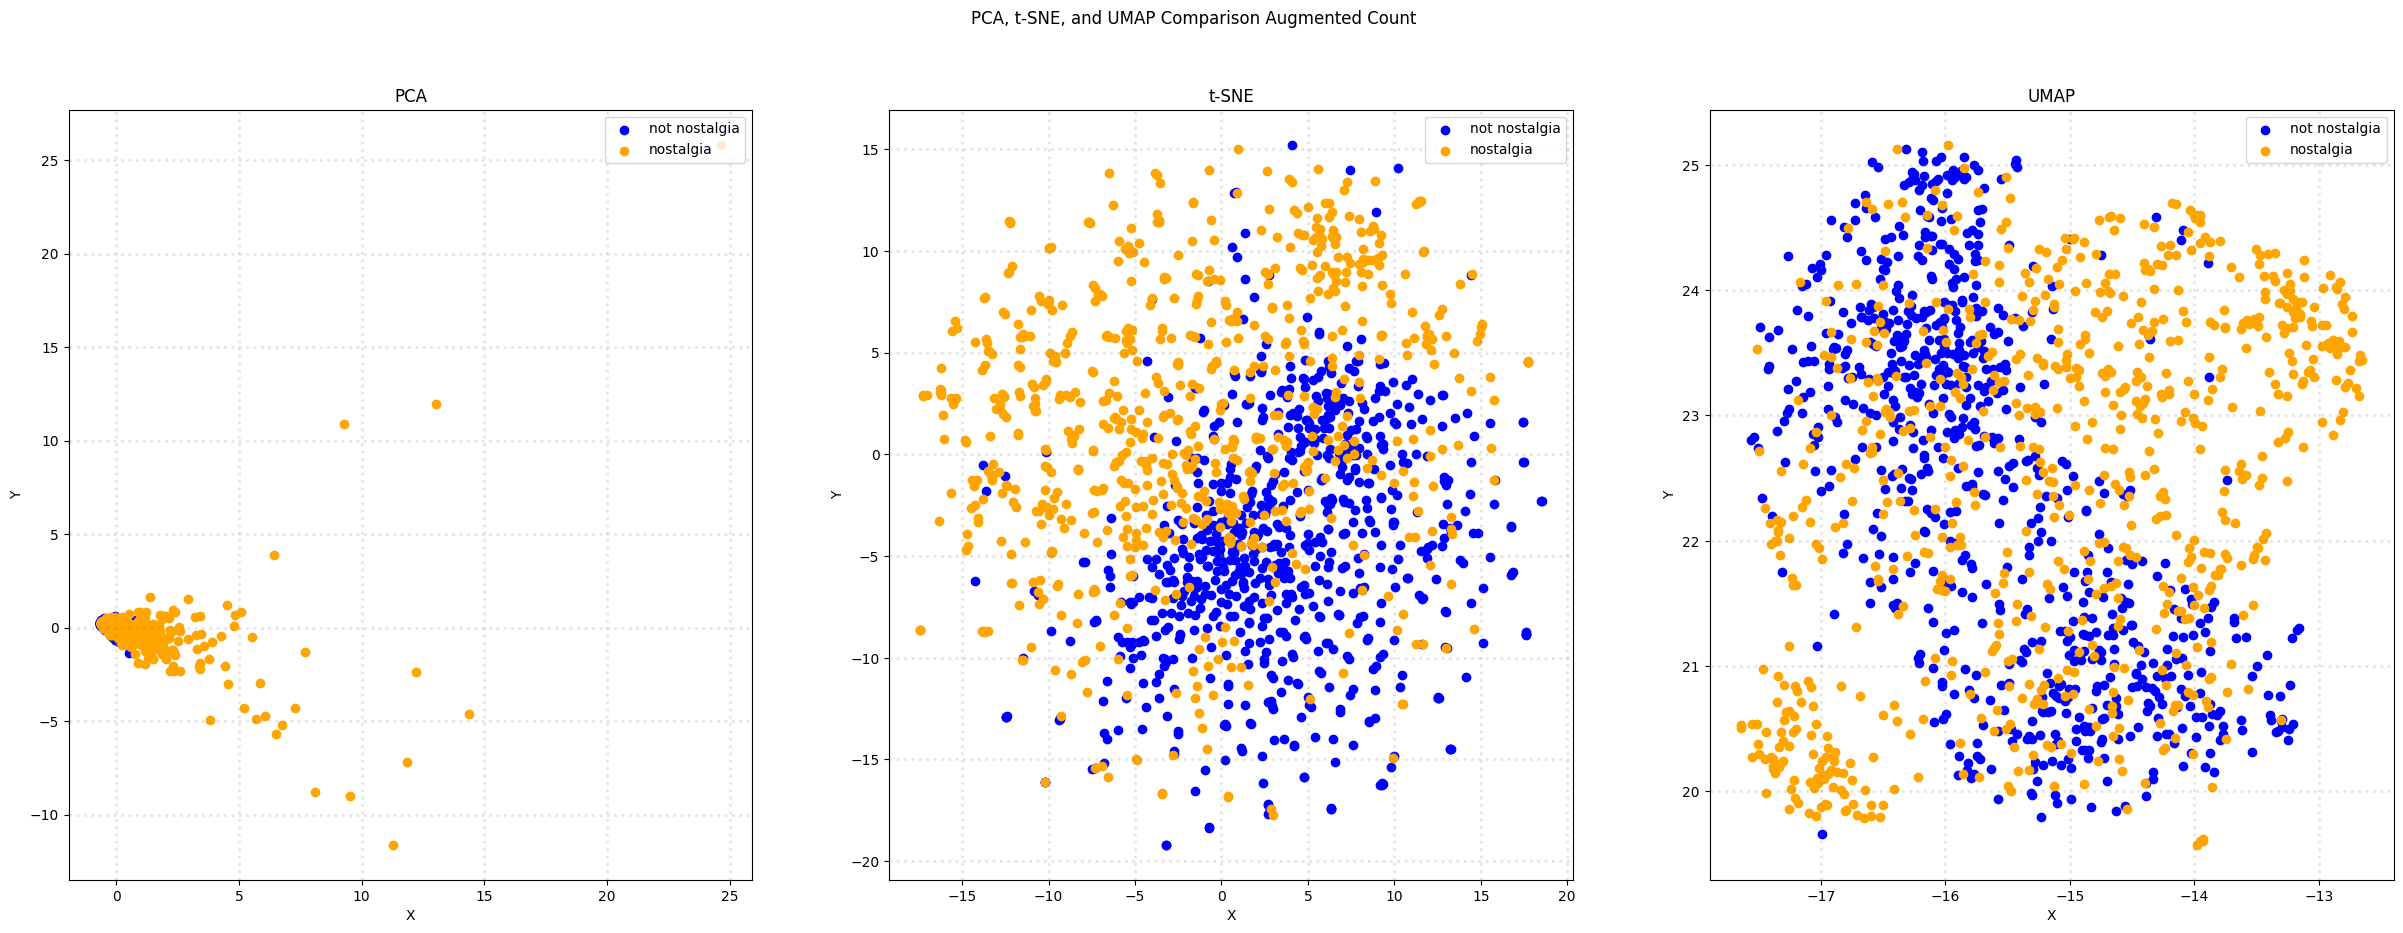

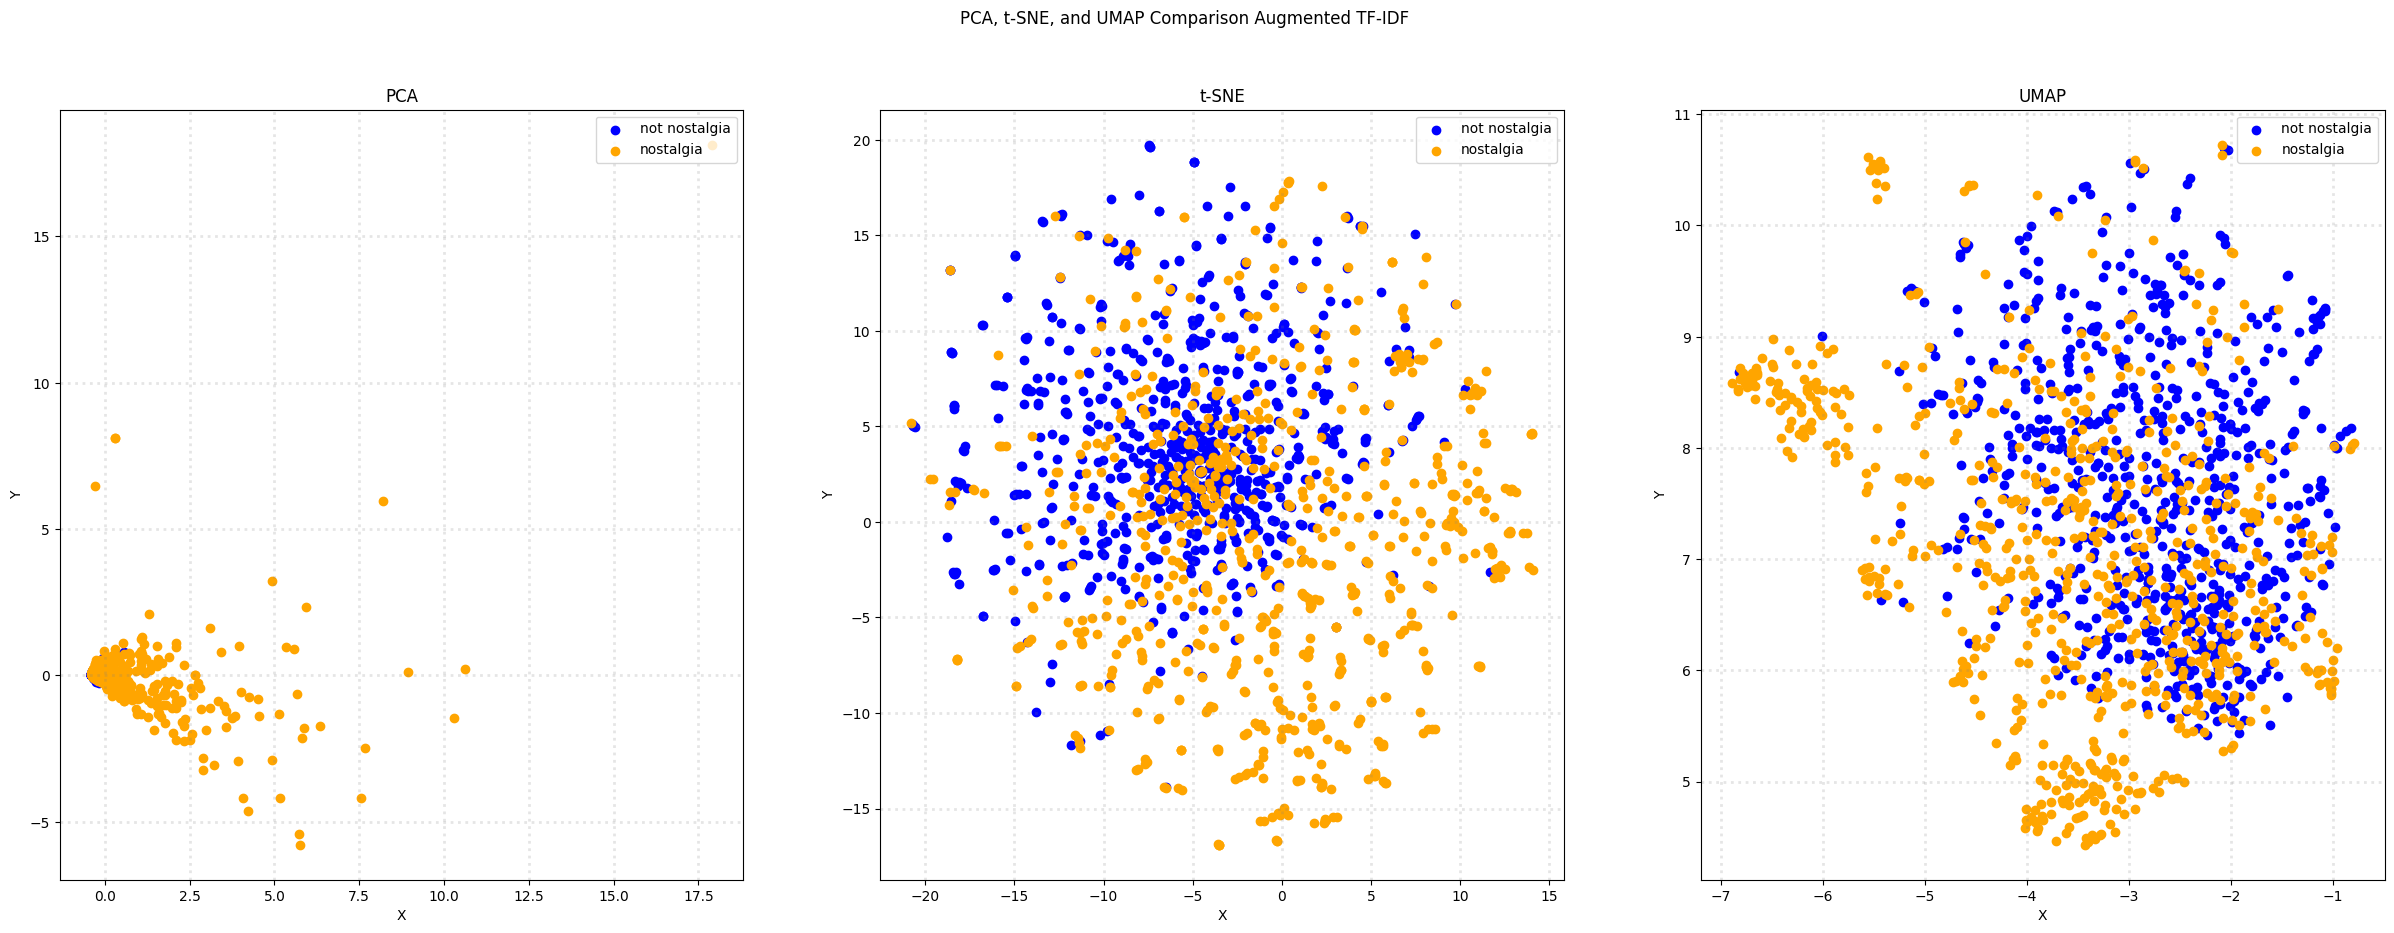

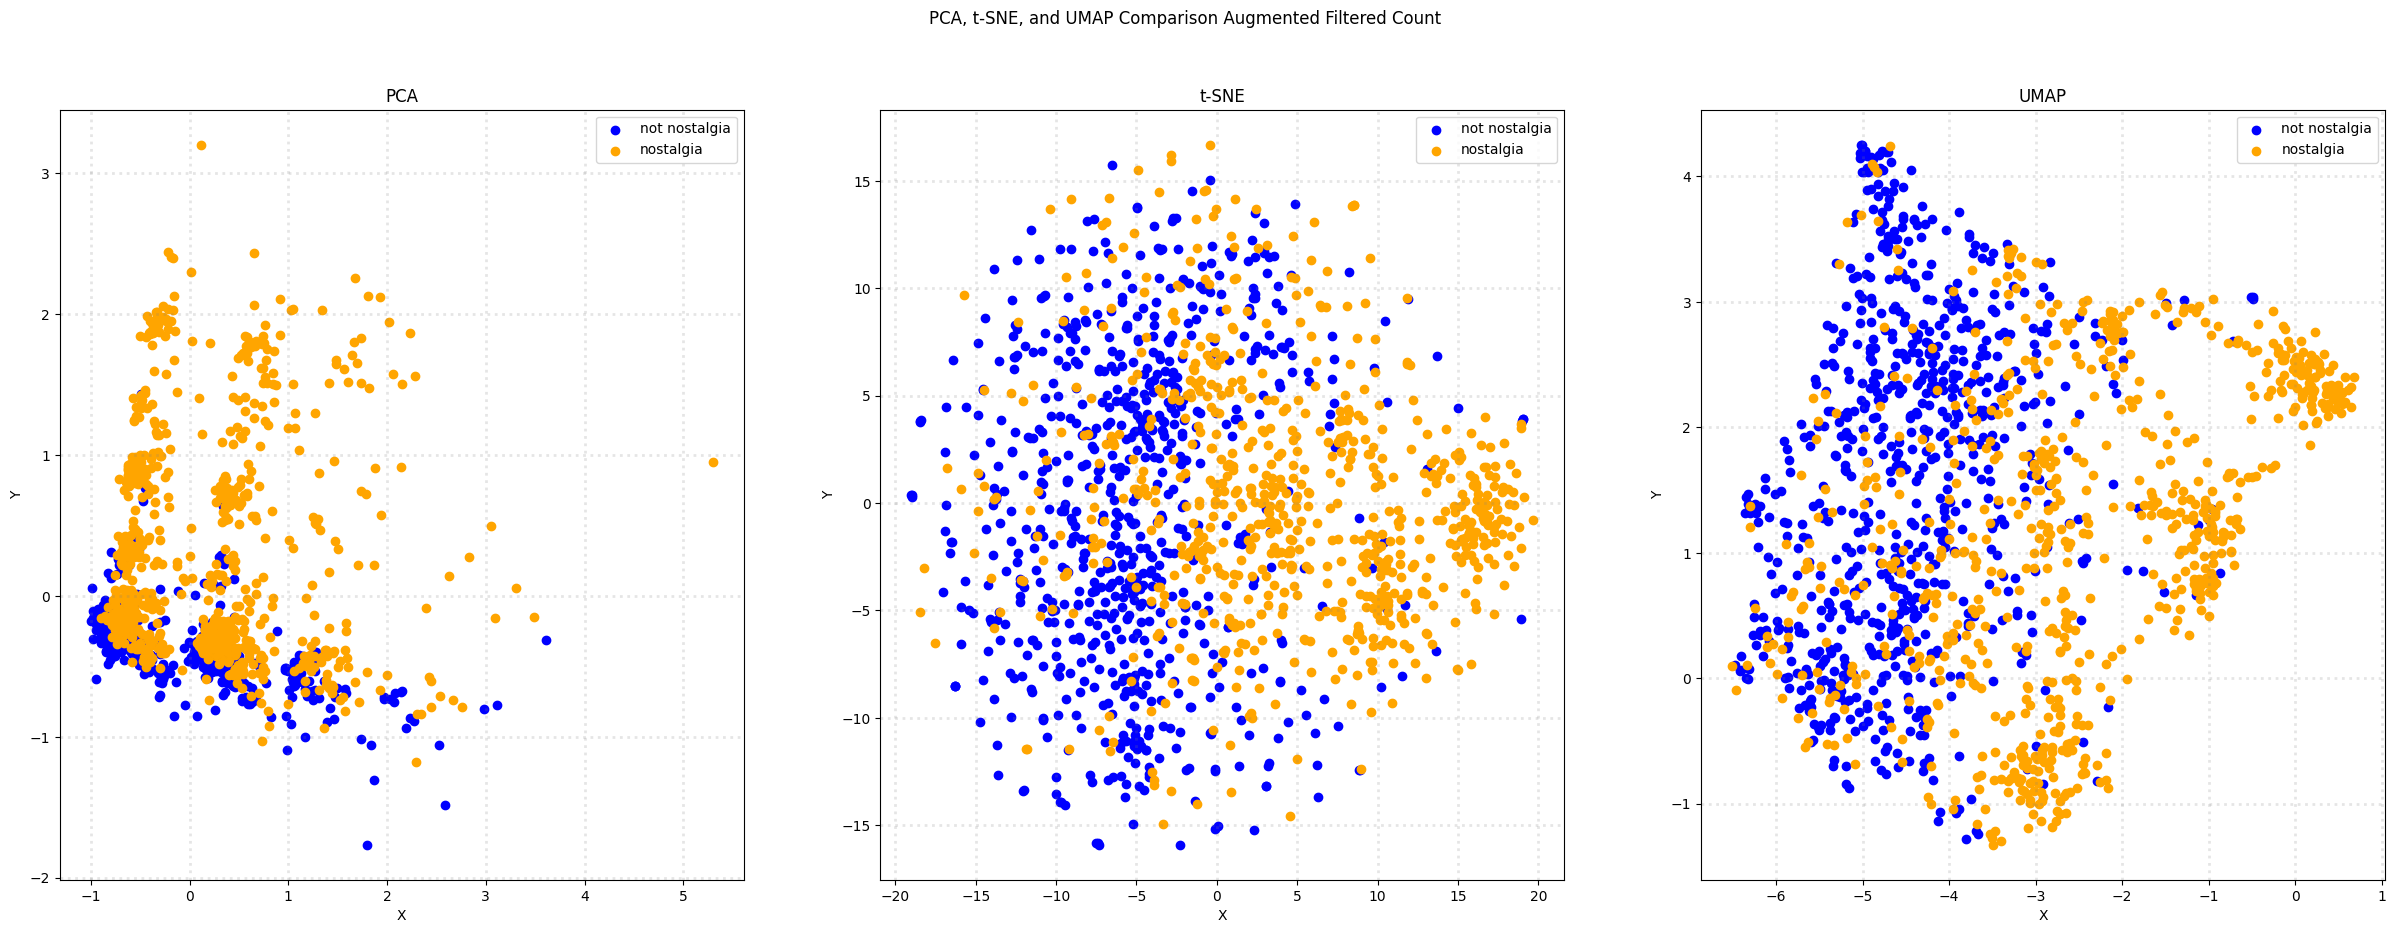

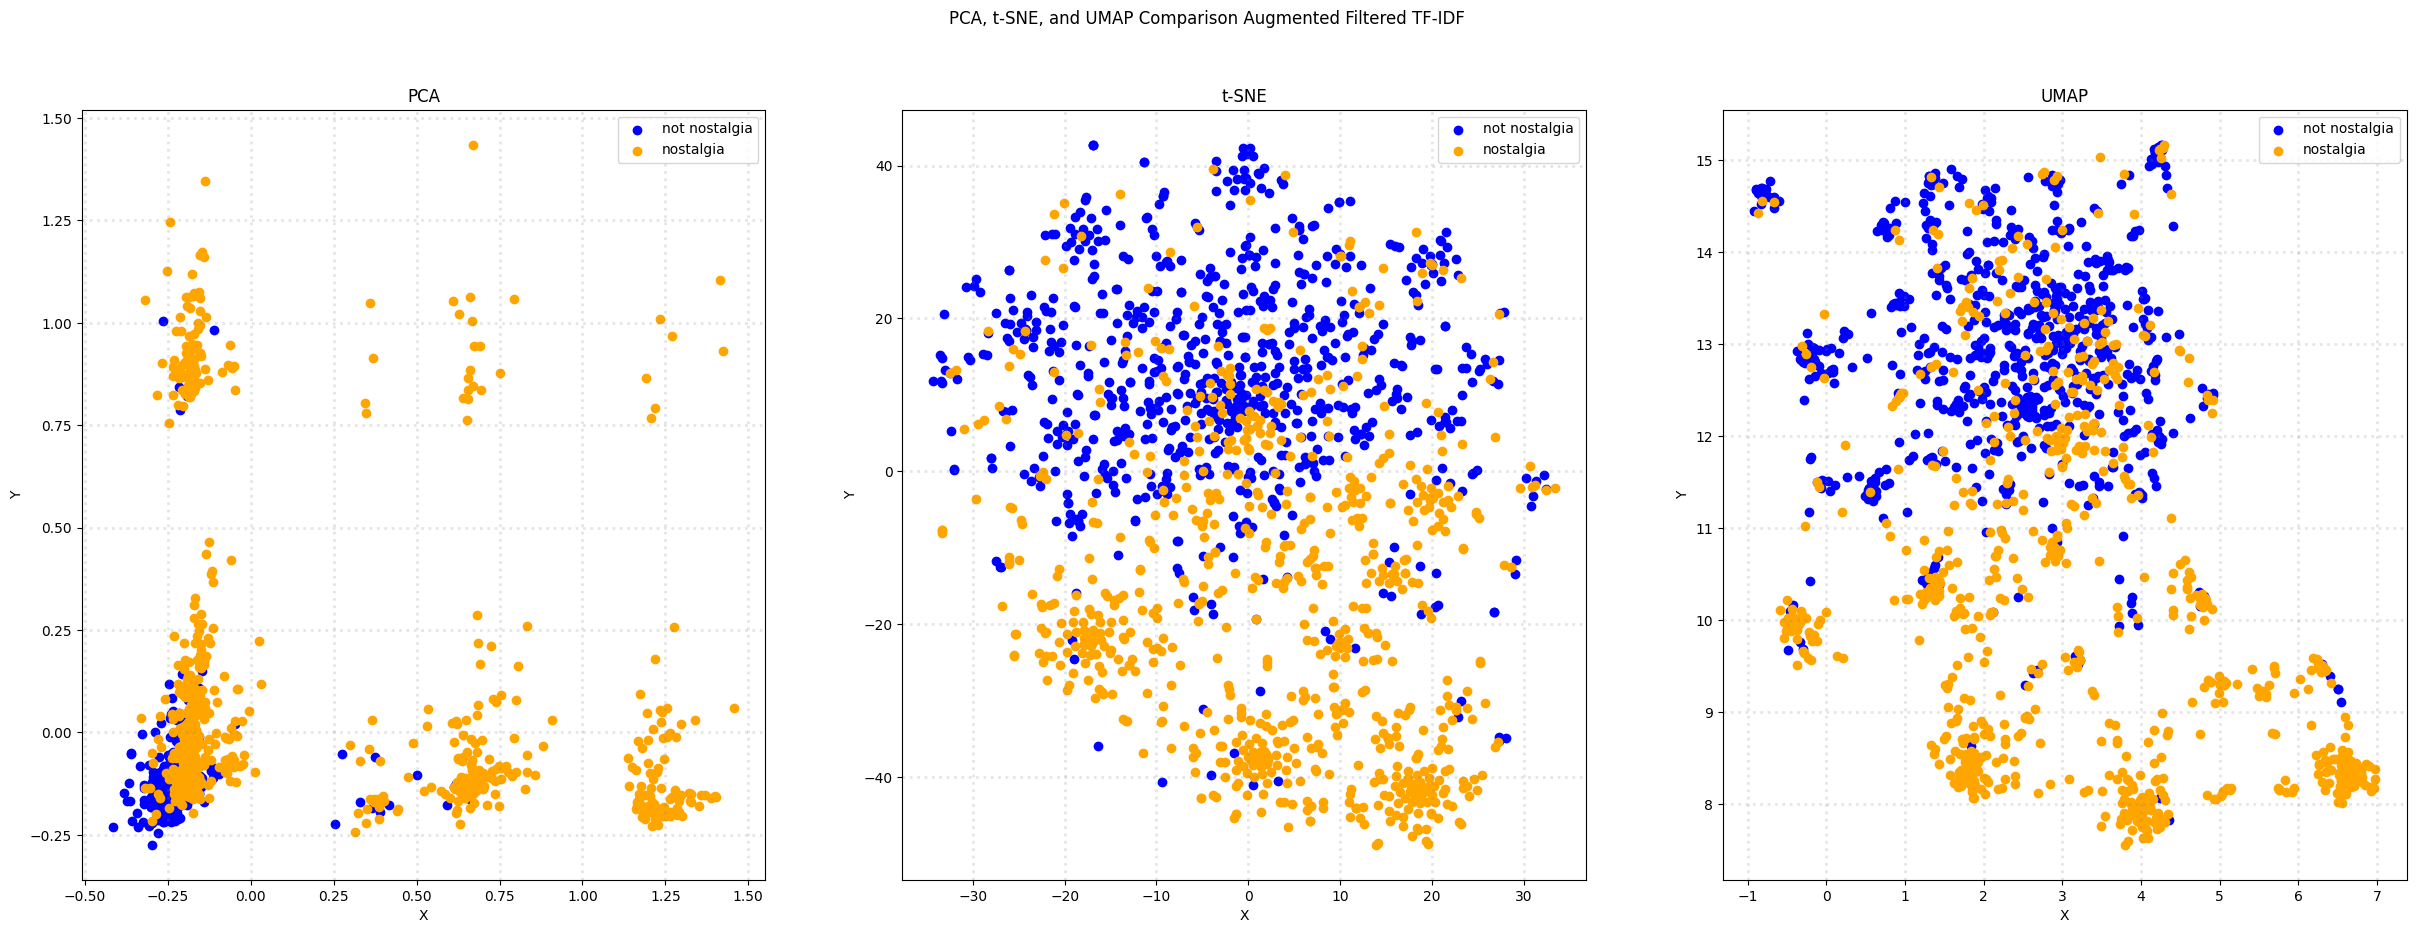

In [45]:
# Define reduction methods and titles for comparison
reduction_methods = [PCA(n_components=2), TSNE(n_components=2), UMAP(n_components=2)]
titles = ['PCA', 't-SNE', 'UMAP']
colors = ['blue', 'orange']
categories = df['sentiment'].unique()  # Replace with actual category values

# Call the function on different datasets
reduce_and_plot(tdm_df_count.values, reduction_methods, titles, 'TDM Count', categories, colors, 'sentiment')
reduce_and_plot(tdm_df_tfidf.values, reduction_methods, titles, 'TDM TF-IDF', categories, colors, 'sentiment')
reduce_and_plot(augmented_dfs['count'].values, reduction_methods, titles, 'Augmented Count', categories, colors, 'sentiment')
reduce_and_plot(augmented_dfs['tfidf'].values, reduction_methods, titles, 'Augmented TF-IDF', categories, colors, 'sentiment')
reduce_and_plot(augmented_dfs['filtered_count'].values, reduction_methods, titles, 'Augmented Filtered Count', categories, colors, 'sentiment')
reduce_and_plot(augmented_dfs['filtered_tfidf'].values, reduction_methods, titles, 'Augmented Filtered TF-IDF', categories, colors, 'sentiment')

### Dimensionality Reduction and 3D Visualization Using Plotly

In [50]:
# Define the function to perform dimensionality reduction and plotting with Plotly
def reduce_and_plot_3d_plotly(data, reduction_methods, method_names, plot_name, sentiment, colors, sentiment_column):
    # Loop through each reduction method and create a 3D scatter plot
    for method, method_name in zip(reduction_methods, method_names):
        # Apply dimensionality reduction
        X_reduced = method.fit_transform(data)
        
        # Create DataFrame for the reduced data with sentiment labels
        reduced_df = pd.DataFrame(X_reduced, columns=['X', 'Y', 'Z'])
        reduced_df[sentiment_column] = sentiment.values
        
        # Generate 3D scatter plot with Plotly
        fig = px.scatter_3d(reduced_df, x='X', y='Y', z='Z', color=sentiment_column, 
                            title=f'{method_name} 3D Scatter Plot for {plot_name}',
                            color_discrete_sequence=colors)
        
        # Customize marker size and layout
        fig.update_traces(marker=dict(size=5))
        fig.update_layout(scene=dict(
            xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
            legend=dict(title=sentiment_column))

        fig.show()

# Define reduction methods and titles for comparison
reduction_methods = [PCA(n_components=3), TSNE(n_components=3), UMAP(n_components=3)]
method_names = ['PCA', 't-SNE', 'UMAP']
colors = ['blue', 'orange']  # Adjust colors as needed
sentiment_column = 'sentiment'
sentiment_data = df[sentiment_column]  # Replace 'df' with the DataFrame containing your sentiment data

# Apply the function on different datasets
reduce_and_plot_3d_plotly(augmented_dfs['count'].values, reduction_methods, method_names, 'Augmented Count', sentiment_data, colors, sentiment_column)
reduce_and_plot_3d_plotly(augmented_dfs['tfidf'].values, reduction_methods, method_names, 'Augmented TF-IDF', sentiment_data, colors, sentiment_column)
reduce_and_plot_3d_plotly(augmented_dfs['filtered_count'].values, reduction_methods, method_names, 'Augmented Filtered Count', sentiment_data, colors, sentiment_column)
reduce_and_plot_3d_plotly(augmented_dfs['filtered_tfidf'].values, reduction_methods, method_names, 'Augmented Filtered TF-IDF', sentiment_data, colors, sentiment_column)

### Document Similarity Calculation Using Cosine Similarity

In [64]:
document_to_transform_1 = [df.iloc[449]['cleaned_comment']]
document_to_transform_2 = [df.iloc[899]['cleaned_comment']]
document_to_transform_3 = [df.iloc[1349]['cleaned_comment']]

In [65]:
print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

['that childhood right']
['angel around us reason wing know foundat creation principl moral valu']
['american band made histori britain due righteou brother walker brother may made famou britain america']


In [66]:
# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [67]:
# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.000000
Cosine Similarity using count bw 1 and 3: 0.000000
Cosine Similarity using count bw 2 and 3: 0.000000
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


### Classifier Evaluation on Different Datasets

In [48]:
# Define classifiers
classifiers = {
    "Multivariate Bernoulli Naive Bayes": BernoulliNB(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
}

# Dictionary to hold various Term Document Matrices (TDMs) and augmented datasets
data = {
    'Term Document Matrix Count Vectorizer': tdm_df_count,
    'Term Document Matrix TF-IDF Vectorizer': tdm_df_tfidf,
    'Augmented TDM and Pattern Matrix Count Vectorizer': augmented_dfs['count'],
    'Augmented Filtered TDM and Pattern Matrix Count Vectorizer': augmented_dfs['filtered_count'],
    'Augmented TDM and Pattern Matrix TF-IDF Vectorizer': augmented_dfs['tfidf'],
    'Augmented Filtered TDM and Pattern Matrix TF-IDF Vectorizer': augmented_dfs['filtered_tfidf'],
}

# Create an empty DataFrame to store results of classifier evaluations
results = pd.DataFrame(columns=['Classifier', 'Dataset', 'Accuracy'])

# Iterate over classifiers
for name, clf in classifiers.items():
    print(f"\n=========================== {name} ==================================")
    for key, value in data.items():
        X_train, X_test, y_train, y_test = train_test_split(value, df['sentiment'], test_size=0.3, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        conf = confusion_matrix(y_test, y_pred)
        results = results.append({'Classifier': name, 'Dataset': key, 'Accuracy': accuracy}, ignore_index=True)
        print(f"\nAccuracy using {key}: {accuracy}")
        print('')
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print('Confusion Matrix: ')
        print('')
        print(conf)


=========================== Multivariate Bernoulli Naive Bayes ==================================

Accuracy using Term Document Matrix Count Vectorizer: 0.8822222222222222

Classification Report:
               precision    recall  f1-score   support

    nostalgia       0.86      0.92      0.89       233
not nostalgia       0.91      0.84      0.87       217

     accuracy                           0.88       450
    macro avg       0.89      0.88      0.88       450
 weighted avg       0.88      0.88      0.88       450

Confusion Matrix: 

[[215  18]
 [ 35 182]]

Accuracy using Term Document Matrix TF-IDF Vectorizer: 0.8822222222222222

Classification Report:
               precision    recall  f1-score   support

    nostalgia       0.86      0.92      0.89       233
not nostalgia       0.91      0.84      0.87       217

     accuracy                           0.88       450
    macro avg       0.89      0.88      0.88       450
 weighted avg       0.88      0.88      0.88       

#### Visualize Classifier Performance

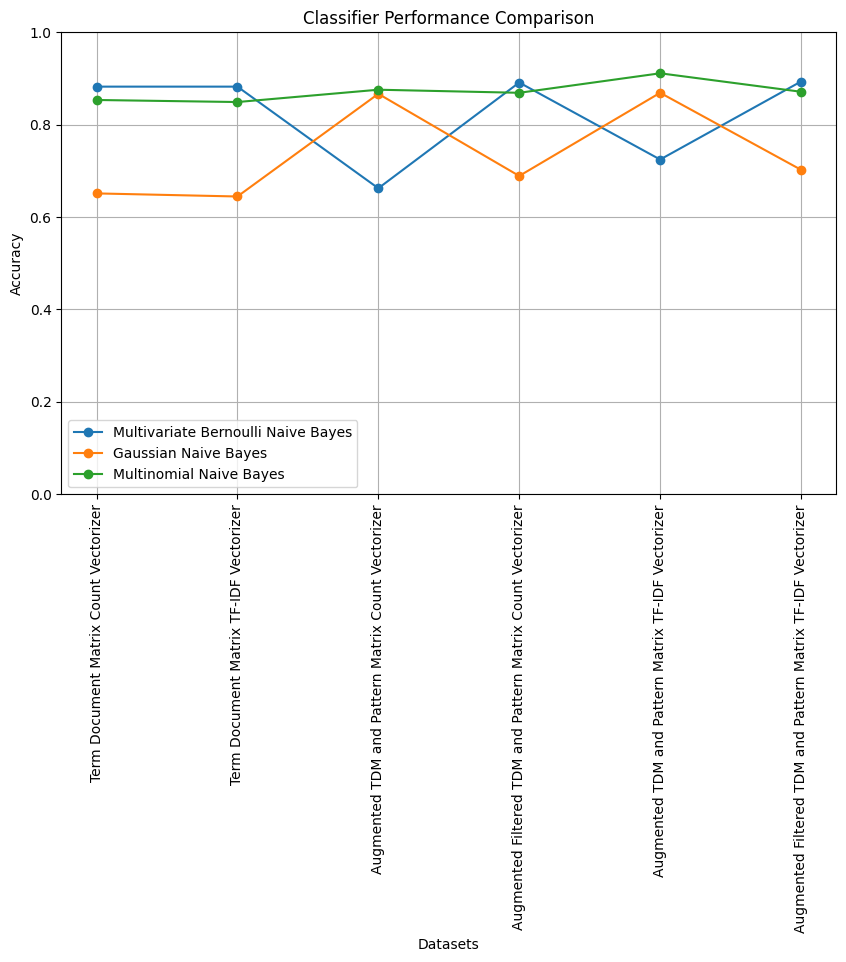

In [49]:
# Plot accuracy comparison for different classifiers across datasets
plt.figure(figsize=(10, 6))
for clf_name in classifiers.keys():
    subset = results[results['Classifier'] == clf_name]
    plt.plot(subset['Dataset'], subset['Accuracy'], marker='o', label=clf_name)

# Configure plot aesthetics
plt.title('Classifier Performance Comparison')
plt.xlabel('Datasets')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

After experimenting with different data, preprocessing techniques, and classifiers. The best accuracy I got was 91%. Thus, I can draw the conclusion that the best result for this nostalgic sentiment analysis of YouTube comments data is by using:

1. Porter Stemmer as the stemmer

2. TF-IDF as the vectorizer

3. FPGrowth algorithm from PAMI with minSupport equal to 3.

4. And use the multinomial Naive Baiyes classifier.